In [884]:
# Dependencies
import requests
import json
from private_info.config import api_key, fromdate, todate
from private_info.opendata_config import token311, password, username
import pandas as pd
from datetime import datetime
import sys
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
# sys.path.append('/path/to/your/dev/environment/lib/python3.10/site-packages')
from sodapy import Socrata
import matplotlib.pyplot as plt


### In the following script we'll try to analize the following
---
##### NYC311 can provide you access to non-emergency City services and information about City government programs. NYC311 can help with a broad range of services, including things like homeless person assistance, pothole repair, or help understanding a property tax bill. over 500 services

- 
-
-
-

### Extracting the the first trimester of 2024 from 311 service request dataset open data 

In [833]:
# Define date range
start_date = datetime(2024, 1, 1).isoformat()  # January 1, 2023
end_date = datetime(2024, 4, 1).isoformat()  # January 1, 2024


# Example authenticated client (needed for non-public datasets):
client = Socrata(
    "data.cityofnewyork.us",
    token311,
    username= username,
    password= password,
    timeout=1000
)

# First 794354 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
# Query dataset with date filter 
#in this case we se a limit of limit=794354 because that's the number of rows we need to get the first trimester, we cannot set it to default because it only retrive 1000 max.
results = client.get("erm2-nwe9", where=f"created_date between '{start_date}' and '{end_date}'", limit=794354)
print(len(results))
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)


794354


In [834]:
#Displaying the 311 service request dataframe 
results_df

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,location,vehicle_type,facility_type,due_date,taxi_pick_up_location,bridge_highway_name,bridge_highway_segment,bridge_highway_direction,road_ramp,taxi_company_borough
0,60746805,2024-04-01T00:00:00.000,2024-04-01T00:00:01.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11211,76 AINSLIE STREET,...,"{'latitude': '40.71256007953489', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,60740007,2024-03-31T23:59:36.000,2024-04-01T05:20:38.000,DOT,Department of Transportation,Street Sign - Damaged,"No Parking, Standing, Stopping",Street,11205,920 KENT AVENUE,...,"{'latitude': '40.693075024696356', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,60734332,2024-03-31T23:59:09.000,2024-04-01T09:12:45.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10454,313 EAST 140 STREET,...,"{'latitude': '40.81154285376075', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,60738841,2024-03-31T23:58:47.000,2024-04-02T22:34:59.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,10128,1670 YORK AVENUE,...,"{'latitude': '40.777070197706855', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,60739109,2024-03-31T23:58:39.000,2024-04-02T15:08:50.000,DOT,Department of Transportation,Street Condition,Defective Hardware,Street,10009,324 EAST 8 STREET,...,"{'latitude': '40.72501024136251', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794349,59887043,2024-01-01T00:00:20.000,2024-01-01T00:41:01.000,NYPD,New York City Police Department,Illegal Fireworks,N/A,Street/Sidewalk,11228,7223 FORT HAMILTON PARKWAY,...,"{'latitude': '40.62709413549678', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794350,59896272,2024-01-01T00:00:00.000,2024-01-02T00:00:01.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11211,145 GRAND STREET EXTENSION,...,"{'latitude': '40.710675306389646', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794351,59899838,2024-01-01T00:00:00.000,2024-01-02T09:42:25.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10022,1069 1 AVENUE,...,"{'latitude': '40.759191822016476', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794352,59894610,2024-01-01T00:00:00.000,2024-01-02T09:46:32.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10304,7 NAVY PIER COURT,...,"{'latitude': '40.628827651071944', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [835]:
#Getting a brief summary of the results_df dataframe 
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794354 entries, 0 to 794353
Data columns (total 41 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   unique_key                      794354 non-null  object
 1   created_date                    794354 non-null  object
 2   closed_date                     774363 non-null  object
 3   agency                          794354 non-null  object
 4   agency_name                     794354 non-null  object
 5   complaint_type                  794354 non-null  object
 6   descriptor                      788994 non-null  object
 7   location_type                   695950 non-null  object
 8   incident_zip                    785089 non-null  object
 9   incident_address                762451 non-null  object
 10  street_name                     762428 non-null  object
 11  cross_street_1                  502948 non-null  object
 12  cross_street_2                

In [836]:
# Get the results_df columns
results_df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'vehicle_type', 'facility_type',
       'due_date', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough'],
      dtype='object')

In [837]:
#Assigning  location and location_subtype values to the location and location_subtype columns 
try:
    results_df[['location_', 'location_subtype']] = results_df['location_type'].str.split("/", n=1, expand=True)

except  ValueError:

    results_df['location_subtype'] = None 
results_df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,facility_type,due_date,taxi_pick_up_location,bridge_highway_name,bridge_highway_segment,bridge_highway_direction,road_ramp,taxi_company_borough,location_,location_subtype
0,60746805,2024-04-01T00:00:00.000,2024-04-01T00:00:01.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11211,76 AINSLIE STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Restaurant,Bar/Deli/Bakery
1,60740007,2024-03-31T23:59:36.000,2024-04-01T05:20:38.000,DOT,Department of Transportation,Street Sign - Damaged,"No Parking, Standing, Stopping",Street,11205,920 KENT AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Street,None
2,60734332,2024-03-31T23:59:09.000,2024-04-01T09:12:45.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10454,313 EAST 140 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESIDENTIAL BUILDING,None
3,60738841,2024-03-31T23:58:47.000,2024-04-02T22:34:59.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,10128,1670 YORK AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESIDENTIAL BUILDING,None
4,60739109,2024-03-31T23:58:39.000,2024-04-02T15:08:50.000,DOT,Department of Transportation,Street Condition,Defective Hardware,Street,10009,324 EAST 8 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Street,None


In [838]:
# Get the results_df columns to check changes 
results_df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'vehicle_type', 'facility_type',
       'due_date', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough', 'location_', 'location_subtype'],
      dtype='object')

In [839]:
#Doucble check how it looks like and the delete the location_type column
results_df[['location_type', 'location_','location_subtype']]
results_df_ = results_df.drop(['location_type'], axis=1)
results_df_.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'vehicle_type', 'facility_type',
       'due_date', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough', 'location_', 'location_subtype'],
      dtype='object')

### Complaints and Boroughs Dataframes
___

In [840]:
complaint_type = results_df['complaint_type'].unique()
complaint_type

print(len(complaint_type))

183


In [841]:
boroughs = results_df['borough'].unique()
boroughs

print(len(boroughs))

6


In [842]:
# Create numpy arrays for the complaints_type
complaints_ids_numbers = np.arange(1, 184)
print(complaints_ids_numbers)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183]


In [843]:
boroughs_ids_numbers = np.arange(1,7)
print(boroughs_ids_numbers)

[1 2 3 4 5 6]


In [844]:
#Use a list comprehension to add "cmpT" to each complaints_ids_number as complaint_id and complaint_type as complaint_type
complaints_ids = ["cmpT" + str(complaint_id) for complaint_id in complaints_ids_numbers]

#Use a list comprehension to add "brgh" to each boroughs_ids_number as complaint_id and complaint_type as complaint_type
boroughs_ids = ['brgh' + str(borough_id) for borough_id in boroughs_ids_numbers]

In [879]:
# Create a borough DataFrame for the borough_ids 

boroughs_df = pd.DataFrame({
    "borough_id": boroughs_ids,
    "borough" : boroughs
})

# Create a category DataFrame for the complaints_ids 

complaints_df = pd.DataFrame({
    "complaint_id": complaints_ids,
    "complaint_type" : complaint_type
})
boroughs_df.head()
complaints_df.tail()

,complaint_id,complaint_type
178,cmpT179,DEP Highway Condition
179,cmpT180,Seasonal Collection
180,cmpT181,DSNY Internal
181,cmpT182,SNW
182,cmpT183,Radioactive Material


In [846]:
# Export complaints_df as CSV files.
complaints_df.to_csv("Resources/complaints.csv", index=False)

In [847]:
# Export boroughs_df as CSV files.
boroughs_df.to_csv("Resources/boroughs.csv", index=False)

### Updating 311 service dataframe datatype
---

In [848]:
# Create a copy of the results_df_ dataframe 
copy_311service_request = results_df_.copy()
copy_311service_request.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,facility_type,due_date,taxi_pick_up_location,bridge_highway_name,bridge_highway_segment,bridge_highway_direction,road_ramp,taxi_company_borough,location_,location_subtype
0,60746805,2024-04-01T00:00:00.000,2024-04-01T00:00:01.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,11211,76 AINSLIE STREET,AINSLIE STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Restaurant,Bar/Deli/Bakery
1,60740007,2024-03-31T23:59:36.000,2024-04-01T05:20:38.000,DOT,Department of Transportation,Street Sign - Damaged,"No Parking, Standing, Stopping",11205,920 KENT AVENUE,KENT AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Street,None
2,60734332,2024-03-31T23:59:09.000,2024-04-01T09:12:45.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,10454,313 EAST 140 STREET,EAST 140 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESIDENTIAL BUILDING,None
3,60738841,2024-03-31T23:58:47.000,2024-04-02T22:34:59.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,10128,1670 YORK AVENUE,YORK AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESIDENTIAL BUILDING,None
4,60739109,2024-03-31T23:58:39.000,2024-04-02T15:08:50.000,DOT,Department of Transportation,Street Condition,Defective Hardware,10009,324 EAST 8 STREET,EAST 8 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Street,None


In [849]:
#Renaming the descriptor column
copy_311service_request = copy_311service_request.rename(columns={'descriptor': 'complaint_descriptor','location_': 'location_type'})

In [850]:
#reordering dataframe with location and location_subtype after descriptor 
# and we're also ignoring the 'agency_name' column since the metadata says that column is currenlty showing incorrect values.
nyc311_service_line = copy_311service_request[['unique_key', 'created_date', 'closed_date', 'agency',
       'complaint_type', 'complaint_descriptor','location_type','location_subtype', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'vehicle_type', 'facility_type',
       'due_date', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough']]

In [851]:
# # Convert the created_date, closed_date, due_date, and resolution_action_updated_date  columns to datetime format

date_columns = ['created_date', 'closed_date', 'due_date', 'resolution_action_updated_date']
for col in date_columns:
    nyc311_service_line[col] = pd.to_datetime(nyc311_service_line[col])


/var/folders/fv/ltttqpzd0bn28sqs0_gjbh300000gn/T/ipykernel_24512/2379949684.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fv/ltttqpzd0bn28sqs0_gjbh300000gn/T/ipykernel_24512/2379949684.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fv/ltttqpzd0bn28sqs0_gjbh300000gn/T/ipykernel_24512/2379949684.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [852]:
# Convert latitude and longitude columns to float format
float_columns = ['latitude', 'longitude']
for float_column in float_columns:
    nyc311_service_line[float_column] = nyc311_service_line[float_column].astype(float)

# # Convert y_coordinate_state_plane and x_coordinate_state_plane columns to integer format
int_columns = ['y_coordinate_state_plane', 'x_coordinate_state_plane']
for int_column in int_columns:
    nyc311_service_line[int_column] = nyc311_service_line[int_column].notnull().astype(int)

#convert incident_zip and unique_key to integer columns 
integers_columns = [ 'incident_zip'] # here we have the columns without Nan values 
for integer_columns in integers_columns:
    nyc311_service_line[integer_columns] = nyc311_service_line[integer_columns].notnull().astype(int)

/var/folders/fv/ltttqpzd0bn28sqs0_gjbh300000gn/T/ipykernel_24512/2074501442.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fv/ltttqpzd0bn28sqs0_gjbh300000gn/T/ipykernel_24512/2074501442.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fv/ltttqpzd0bn28sqs0_gjbh300000gn/T/ipykernel_24512/2074501442.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [853]:
# Checking the datatypes
nyc311_service_line.dtypes

unique_key                                object
created_date                      datetime64[ns]
closed_date                       datetime64[ns]
agency                                    object
complaint_type                            object
complaint_descriptor                      object
location_type                             object
location_subtype                          object
incident_zip                               int64
incident_address                          object
street_name                               object
cross_street_1                            object
cross_street_2                            object
intersection_street_1                     object
intersection_street_2                     object
address_type                              object
city                                      object
landmark                                  object
status                                    object
resolution_description                    object
resolution_action_up

In [855]:
# Merge the campaign_df with the category_df on the "category" column and
# the subcategory_df on the "subcategory" column.

nyc311_merged_df = nyc311_service_line.merge(complaints_df, on='complaint_type', how='left').merge(boroughs_df, on='borough', how='left')
nyc311_merged_df.tail(10)


,unique_key,created_date,closed_date,agency,complaint_type,complaint_descriptor,location_type,location_subtype,incident_zip,incident_address,...,facility_type,due_date,taxi_pick_up_location,bridge_highway_name,bridge_highway_segment,bridge_highway_direction,road_ramp,taxi_company_borough,complaint_id,borough_id
794344,59889054,2024-01-01 00:00:51,2024-01-01 00:29:32,NYPD,Noise - Street/Sidewalk,Loud Music/Party,Street,Sidewalk,1,85-04 95 AVENUE,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT8,brgh4
794345,59892651,2024-01-01 00:00:48,2024-01-01 00:48:34,NYPD,Noise - Street/Sidewalk,Loud Music/Party,Street,Sidewalk,1,41-52 72 STREET,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT8,brgh4
794346,59891528,2024-01-01 00:00:46,2024-01-01 01:07:17,NYPD,Illegal Fireworks,N/A,Residential Building,House,1,106-23 75 STREET,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT82,brgh4
794347,59888940,2024-01-01 00:00:43,2024-01-01 00:56:45,NYPD,Noise - Residential,Banging/Pounding,Residential Building,House,1,640 STANLEY AVENUE,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT5,brgh1
794348,59889016,2024-01-01 00:00:20,2024-01-01 00:59:31,NYPD,Noise - Residential,Loud Music/Party,Residential Building,House,1,233 LANDING ROAD,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT5,brgh2
794349,59887043,2024-01-01 00:00:20,2024-01-01 00:41:01,NYPD,Illegal Fireworks,N/A,Street,Sidewalk,1,7223 FORT HAMILTON PARKWAY,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT82,brgh1
794350,59896272,2024-01-01 00:00:00,2024-01-02 00:00:01,DOHMH,Food Poisoning,1 or 2,Restaurant,Bar/Deli/Bakery,1,145 GRAND STREET EXTENSION,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT1,brgh1
794351,59899838,2024-01-01 00:00:00,2024-01-02 09:42:25,DOHMH,Food Poisoning,1 or 2,Restaurant,Bar/Deli/Bakery,1,1069 1 AVENUE,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT1,brgh3
794352,59894610,2024-01-01 00:00:00,2024-01-02 09:46:32,DOHMH,Food Poisoning,1 or 2,Restaurant,Bar/Deli/Bakery,1,7 NAVY PIER COURT,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT1,brgh5
794353,59898042,2024-01-01 00:00:00,2024-01-02 09:24:45,DOHMH,Food Poisoning,1 or 2,Restaurant,Bar/Deli/Bakery,1,711 MORRIS PARK AVENUE,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT1,brgh2


In [880]:

# Export the  nyc311_service_line DataFrame as a CSV file. 
nyc311_merged_df.to_csv("Resources/nyc311_merged_df.csv", index=False)

#   Analysis

 ### Which are the top 10 most popular report ploblems 311 receives?
 -----
 

In [857]:
#This first dataframe answer the first question to analyse 
complaints_311 = nyc311_service_line.groupby("complaint_type")["unique_key"].count().reset_index().sort_values(by='unique_key', ascending=False)
top_10_complaints =  complaints_311.reset_index(drop=True).head(10)
#here we decided to add this commas for better reading since 
top_10_complaints['unique_key'] = top_10_complaints['unique_key'].map("{:,}".format)
top_10_complaints.rename(columns = {"unique_key": "unique_key_count"})
top_10_complaints.index = top_10_complaints.index + 1
top_10_complaints


,complaint_type,unique_key
1,Illegal Parking,"123,083"
2,HEAT/HOT WATER,"106,450"
3,Noise - Residential,"68,498"
4,Blocked Driveway,"43,067"
5,UNSANITARY CONDITION,"28,192"
6,Street Condition,"19,016"
7,Abandoned Vehicle,"17,625"
8,PLUMBING,"17,406"
9,PAINT/PLASTER,"17,331"
10,Noise - Street/Sidewalk,"15,722"


In [858]:
#Here we are creating the a bar chart to present the top 10 complaints types 
fig_top_10_complaints = px.bar(top_10_complaints, x='unique_key', y='complaint_type', 
                               title="Top 10 Complaint Types",
                               labels={'complaint_type':'Complaint Types',
                                       'unique_key': 'Amount of Incidents'})
fig_top_10_complaints.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)')
fig_top_10_complaints.show()

In [859]:
#Here we decided to create a fuction to look for the top 10 complaint type during the course of the three first months of the years to not repeat ourselves :

def analyze_complaint_types(start_date, end_date, data):
    # Filter data based on the specified start and end dates
    complaints_data = data.loc[(data['created_date'].dt.date >= start_date) & 
                               (data['created_date'].dt.date <= end_date), :]
    
    # Group by complaint type and count the unique keys
    complaints_grouped = complaints_data.groupby("complaint_type")["unique_key"].count().reset_index().sort_values(by='unique_key', ascending=False)
    
    # Get the top 10 complaint types
    top_10_complaints = complaints_grouped.reset_index(drop=True).head(10)
    
    # Format the unique key count
    top_10_complaints['unique_key'] = top_10_complaints['unique_key'].map("{:,}".format)
    
    # Rename the column
    top_10_complaints.rename(columns={"unique_key": "unique_key_count"}, inplace=True)
    
    # Adjust the index to start from 1
    top_10_complaints.index = top_10_complaints.index + 1
    
    return top_10_complaints

In [860]:
#how have the complaint types change over othe course of these there months 
# Convert date strings to datetime objects
start_date_jan = pd.to_datetime('2024-01-01').date()
end_date_jan = pd.to_datetime('2024-01-31').date()

top_10_complaints_jan =  analyze_complaint_types(start_date_jan, end_date_jan, nyc311_service_line)
top_10_complaints_jan['Month'] = 'January'
top_10_complaints_jan


,complaint_type,unique_key_count,Month
1,HEAT/HOT WATER,"51,325",January
2,Illegal Parking,"41,124",January
3,Noise - Residential,"22,091",January
4,Blocked Driveway,"14,966",January
5,UNSANITARY CONDITION,"10,720",January
6,PLUMBING,"6,800",January
7,PAINT/PLASTER,"6,755",January
8,Abandoned Vehicle,"6,079",January
9,WATER LEAK,"5,863",January
10,Traffic Signal Condition,"5,225",January


In [861]:
#Feb analysis
# Convert date strings to datetime objects
start_date_feb = pd.to_datetime('2024-02-01').date()
end_date_feb = pd.to_datetime('2024-02-29').date()


top_10_complaints_feb =  analyze_complaint_types(start_date_feb, end_date_feb, nyc311_service_line)
top_10_complaints_feb['Month'] = 'February'
top_10_complaints_feb


,complaint_type,unique_key_count,Month
1,Illegal Parking,"38,792",February
2,HEAT/HOT WATER,"30,316",February
3,Noise - Residential,"21,511",February
4,Blocked Driveway,"13,642",February
5,UNSANITARY CONDITION,"8,488",February
6,Street Condition,"5,870",February
7,Abandoned Vehicle,"5,387",February
8,PLUMBING,"5,260",February
9,PAINT/PLASTER,"4,970",February
10,Noise - Commercial,"4,552",February


In [862]:
#March analysis
# Convert date strings to datetime objects
start_date_march = pd.to_datetime('2024-03-01').date()
end_date_march = pd.to_datetime('2024-03-31').date()

top_10_complaints_march =  analyze_complaint_types(start_date_march, end_date_march, nyc311_service_line)
top_10_complaints_march['Month'] = 'March'
top_10_complaints_march


,complaint_type,unique_key_count,Month
1,Illegal Parking,"43,167",March
2,Noise - Residential,"24,896",March
3,HEAT/HOT WATER,"24,809",March
4,Blocked Driveway,"14,459",March
5,UNSANITARY CONDITION,"8,984",March
6,Street Condition,"8,142",March
7,Noise - Street/Sidewalk,"7,609",March
8,Noise - Commercial,"6,376",March
9,Abandoned Vehicle,"6,159",March
10,PAINT/PLASTER,"5,606",March


In [863]:
#Here we're concatenating our code in order to built a bar chart presentating the fluctuation of complaint types for those three months 

# Combine the dataframes
combined_df = pd.concat([top_10_complaints_jan, top_10_complaints_feb, top_10_complaints_march], ignore_index=True)

# Ensure 'unique_key_count' is numeric
combined_df['unique_key_count'] = combined_df['unique_key_count'].str.replace(',', '').astype(int)
# ------------------------------------

# Define colors
colors = {
    'January': 'rgb(158,202,225)',
    'February': 'rgb(135,206,235)',  # Sky Blue
    'March': 'rgb(70,130,180)'       # Steel Blue
}

# Create the bar chart
fig_top_10_complaints_overtime = px.bar(
    combined_df, 
    x='complaint_type', 
    y='unique_key_count', 
    color='Month', 
    color_discrete_map=colors,  # Apply color scheme
    barmode='group',            # Group bars by month
    title="Top 10 Complaint Types Over Time",
    labels={'complaint_type': 'Complaint Types', 'unique_key_count': 'Number of Complaints'}
)

# Customize the layout
fig_top_10_complaints_overtime.update_layout(
    xaxis_title='Complaint Types',
    yaxis_title='Number of Complaints',
    xaxis_tickangle=-45  # Rotate x-axis labels for better readability
)

# Show the plot
fig_top_10_complaints_overtime.show()

In [864]:
#here we decided to dive deeper and make the same analysis but by borough

# borough_index311 = nyc311_service_line.set_index(['borough', 'complaint_type'])
complaints_by_borough = nyc311_service_line.groupby(["borough", "complaint_type"])["unique_key"].count().reset_index()
complaints_by_borough_sorted = complaints_by_borough.sort_values(by=['borough', 'unique_key'], ascending=[True, False])
top_10_complaints_by_borough = complaints_by_borough_sorted.groupby('borough').head(10).reset_index(drop=True)
top_10_complaints_by_borough['rank'] = top_10_complaints_by_borough.groupby('borough').cumcount( ascending= True)+1
top_10_complaints_by_borough.set_index(['borough', 'rank'], inplace=True)
top_10_complaints_by_borough['unique_key'] = top_10_complaints_by_borough['unique_key'].map("{:,}".format)
top_10_complaints_by_borough


complaint_type unique_key
borough       rank                                       
BRONX         1                 HEAT/HOT WATER     39,312
              2                Illegal Parking     18,466
              3            Noise - Residential     17,944
              4           UNSANITARY CONDITION      9,521
              5               Blocked Driveway      6,367
              6                  PAINT/PLASTER      6,306
              7                       PLUMBING      6,059
              8                     WATER LEAK      4,517
              9                    DOOR/WINDOW      4,488
              10             Derelict Vehicles      2,953
BROOKLYN      1                Illegal Parking     47,599
              2                 HEAT/HOT WATER     26,906
              3            Noise - Residential     20,500
              4               Blocked Driveway     16,436
              5           UNSANITARY CONDITION      8,458
              6              Abandoned Vehicle      6,557
              7                       PLUMBING      5,142
              8                  PAINT/PLASTER      5,120
              9             Noise - Commercial      4,878
              10                    WATER LEAK      4,770
MANHATTAN     1                 HEAT/HOT WATER     23,341
              2                Illegal Parking     17,072
              3            Noise - Residential     14,808
              4        Noise - Street/Sidewalk      6,538
              5             Noise - Commercial      5,370
              6                          Noise      5,360
              7           UNSANITARY CONDITION      5,335
              8             Noise - Helicopter      4,686
              9                     Encampment      4,672
              10    For Hire Vehicle Complaint      3,855
QUEENS        1                Illegal Parking     36,358
              2               Blocked Driveway     17,947
              3                 HEAT/HOT WATER     15,756
              4            Noise - Residential     13,720
              5              Abandoned Vehicle      6,980
              6               Street Condition      6,771
              7           UNSANITARY CONDITION      4,209
              8              Derelict Vehicles      3,948
              9       Traffic Signal Condition      3,883
              10                 Drug Activity      3,729
STATEN ISLAND 1                Illegal Parking      3,580
              2               Street Condition      2,466
              3            Noise - Residential      1,524
              4              Abandoned Vehicle      1,142
              5                 HEAT/HOT WATER      1,135
              6               Blocked Driveway      1,131
              7                   Water System      1,038
              8                          Sewer        901
              9                Dirty Condition        816
              10             Missed Collection        754
Unspecified   1                  Ferry Inquiry         75
              2                 Taxi Complaint         71
              3       Traffic Signal Condition         63
              4     For Hire Vehicle Complaint         57
              5                Ferry Complaint         55
              6              Derelict Vehicles         48
              7               Street Condition         45
              8             Consumer Complaint         43
              9             Food Establishment         31
              10        Street Light Condition         22

### Resolution Time Per Complaint (top 10)
---

In [865]:
#Create a list of the top 10 complaints
top_ten_complaints_list = list(top_10_complaints['complaint_type'])

#create a resolution response time column 
nyc311_time = nyc311_time.assign(resolution_response_time = lambda x: (x['resolution_action_updated_date'] - x['created_date']))
#substract the data in days and hours 
nyc311_time['resolution_response_days'] = nyc311_time['resolution_response_time'].dt.days
nyc311_time['resolution_response_hours'] = nyc311_time['resolution_response_time'].dt.total_seconds() / 3600
#group by complaint type and the filter by the top_ten_complaints_list 
avg_resolution_timedf = nyc311_time.groupby(['complaint_type'])['resolution_response_time'].mean().reset_index().sort_values(by='resolution_response_time', ascending=False,na_position='first')
avg_resolution_timedf = avg_resolution_timedf.loc[(avg_resolution_timedf['complaint_type'].isin(top_ten_complaints_list)), :]
avg_resolution_timedf.reset_index(drop=True, inplace=True)
avg_resolution_timedf.index = avg_resolution_timedf.index +1 

#check datatype
avg_resolution_timedf.dtypes

#Convert timedelta to hours, minutes, and seconds
avg_resolution_timedf['total_hours'] = avg_resolution_timedf['resolution_response_time'].dt.components['days'] * 24 + avg_resolution_timedf['resolution_response_time'].dt.components['hours']
avg_resolution_timedf['days'] = avg_resolution_timedf['resolution_response_time'].dt.components['days'] 
avg_resolution_timedf['hours'] = avg_resolution_timedf['resolution_response_time'].dt.components['hours']
avg_resolution_timedf['minutes'] = avg_resolution_timedf['resolution_response_time'].dt.components['minutes']
avg_resolution_timedf['seconds'] = avg_resolution_timedf['resolution_response_time'].dt.components['seconds']


avg_resolution_timedf


,complaint_type,resolution_response_time,total_hours,days,hours,minutes,seconds
1,UNSANITARY CONDITION,24 days 05:20:10.163406340,581,24,5,20,10
2,PLUMBING,22 days 09:48:49.939009588,537,22,9,48,49
3,PAINT/PLASTER,19 days 22:11:28.008928571,478,19,22,11,28
4,Street Condition,2 days 07:59:53.776801683,55,2,7,59,53
5,HEAT/HOT WATER,1 days 02:54:16.860314246,26,1,2,54,16
6,Abandoned Vehicle,0 days 03:30:40.776794326,3,0,3,30,40
7,Blocked Driveway,0 days 02:44:07.980773696,2,0,2,44,7
8,Illegal Parking,0 days 02:26:27.249928909,2,0,2,26,27
9,Noise - Residential,0 days 01:10:32.740926742,1,0,1,10,32
10,Noise - Street/Sidewalk,0 days 00:50:57.662638341,0,0,0,50,57


In [866]:
#Barchart for the average resolution time they take per 10 complaint types

fig_top_10_avg_resolution_time = px.bar(avg_resolution_timedf, x="total_hours", y="complaint_type", orientation='h',
                                        title='Average Resolution Time (days)',
                                        labels={'total_hours': 'Avergae Resolution Time (hours)',
                                                'complaint_type': 'Complaint Type'})
fig_top_10_avg_resolution_time.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)')
fig_top_10_avg_resolution_time.show()



### Volume Of Incidents Overtime
__________

In [867]:
#Volume of calls 311 has receive 
indicent_total_vol = len(nyc311_service_line['unique_key'].unique())
indicent_total_vol

794354

In [868]:
#Function to determine the total volume of calls per months 

def volume_per_month(start_date, end_date, data):
    
    calls_total_vol_df = data.loc[(nyc311_service_line['created_date'].dt.date >= start_date) &
                                                (nyc311_service_line['created_date'].dt.date <= end_date), :]
    calls_total_vol_jan = len(calls_total_vol_df['unique_key'].unique())

    return  calls_total_vol_jan


In [869]:
start_date_jan = pd.to_datetime('2024-01-01').date()
end_date_jan = pd.to_datetime('2024-01-31').date()

incident_total_vol_jan = volume_per_month(start_date_jan, end_date_jan, nyc311_service_line)
incident_total_vol_jan

287200

In [870]:
start_date_feb = pd.to_datetime('2024-02-01').date()
end_date_feb = pd.to_datetime('2024-02-29').date()

incident_total_vol_feb = volume_per_month(start_date_feb, end_date_feb, nyc311_service_line)
incident_total_vol_feb

240454

In [871]:
start_date_march = pd.to_datetime('2024-03-01').date()
end_date_march = pd.to_datetime('2024-03-31').date()

incident_total_vol_march = volume_per_month(start_date_march, end_date_march, nyc311_service_line)
incident_total_vol_march

266699

In [872]:
# Create snapshot key volume's metrics in a DataFrame
incidents_vol_df = pd.DataFrame({"Total Indicents": [indicent_total_vol],
                                 "Total Indicents in January": incident_total_vol_jan,
                                 "Total Indicents in February":incident_total_vol_feb,
                                 "Total Indicents in March":incident_total_vol_march
                                 })

# Formatting
incidents_vol_df["Total Indicents"] = incidents_vol_df["Total Indicents"].map("{:,}".format)
incidents_vol_df["Total Indicents in January"] = incidents_vol_df["Total Indicents in January"].map("{:,}".format)
incidents_vol_df["Total Indicents in February"] = incidents_vol_df["Total Indicents in February"].map("{:,}".format)
incidents_vol_df["Total Indicents in March"] = incidents_vol_df["Total Indicents in March"].map("{:,}".format)

# Display the DataFrame
incidents_vol_df

,Total Indicents,Total Indicents in January,Total Indicents in February,Total Indicents in March
0,"794,354","287,200","240,454","266,699"


In [873]:
#Line chart for incidents  over time 
incidents_overtime = nyc311_time.loc[nyc311_time['month'] < 4, :]
incidents_by_months = incidents_overtime.groupby(['month'])['month'].count().reset_index(name='Count')
incidents_by_months

#Create line chart 
fig_incidents_overtime = px.line(incidents_by_months, x="month", y="Count",
                                 title='Volume Of Incidents Overtime',
                                        labels={'Count': 'Volume Of Incidents',
                                                'month': 'Months'})
fig_incidents_overtime.update_traces(textposition="bottom right",marker_color='rgb(158,202,225)')
fig_incidents_overtime.show()

In [874]:
#This is another line chart with the top 5 complaints over time 
#Query the data to be used in the line chart
top_ten_incidents_overtime = incidents_overtime.loc[(incidents_overtime['complaint_type'].isin(top_ten_complaints_list[0:5])), :]
complaints_by_type_month = top_ten_incidents_overtime.groupby(['month', 'complaint_type'])['month'].count().reset_index(name='Count')
complaints_by_type_month

# Create the line chart
fig_complaints_by_type_month = px.line(complaints_by_type_month, x="month", y="Count", color='complaint_type',
                                       title='Volume Of Incidents Per Complaint Types Overtime (top 5) ',
                                        labels={'Count': 'Volume Of Incidents',
                                                'month': 'Months'})
fig_complaints_by_type_month.update_traces(textposition="bottom right")
fig_complaints_by_type_month.show()

In [875]:
#Here we decided to create a DataFrame with the amount of incidents per day of the week to verify if there's a pattern

# Group by day and count occurrences
day_counts = nyc311_time.groupby('day').size().reset_index(name='incidents_count')
day_counts
# Sort by count in descending order and get the top 10 days
top10_days = day_counts.sort_values(by='incidents_count', ascending=False).head(10)

# Reorder 'day' based on 'Count' for better plotting
top10_days['day'] = pd.Categorical(top10_days['day'], categories=top10_days['day'].tolist(), ordered=True)
top10_days = top10_days.sort_values('day')

day_counts['incidents_count'] = day_counts['incidents_count'].map("{:,}".format)
day_counts.index = day_counts.index +1 
day_counts

,day,incidents_count
1,Friday,"109,253"
2,Monday,"111,702"
3,Saturday,"94,613"
4,Sunday,"95,950"
5,Thursday,"115,031"
6,Tuesday,"114,958"
7,Wednesday,"113,529"


In [876]:
#Here we decided to create a DataFrame with displaying the busiest week of the month to verify if there's a trend

# Add a 'week_of_month' column
nyc311_time['week_of_month'] = ((nyc311_time['created_date'].dt.day - 1) // 7) + 1

# Count complaints per week of each month
weekly_counts = nyc311_time.groupby(['year', 'month', 'week_of_month']).size().reset_index(name='complaint_count')

# Find the busiest week for each month
busiest_weeks = weekly_counts.loc[weekly_counts.groupby(['year', 'month'])['complaint_count'].idxmax()]
print("Busiest Week of Each Month:\n")
busiest_weeks


Busiest Week of Each Month:



,year,month,week_of_month,complaint_count
2,2024,1,3,66066
5,2024,2,1,57737
11,2024,3,2,59573
15,2024,4,1,1


### What burough has the highest level of 311 calls?
---

In [882]:
# check the amount of time each borough is reported 
boroughs_df = pd.DataFrame(nyc311_service_line['borough']).value_counts().reset_index()
boroughs_df

,borough,count
0,BROOKLYN,247148
1,QUEENS,190308
2,MANHATTAN,165901
3,BRONX,162956
4,STATEN ISLAND,27423
5,Unspecified,618


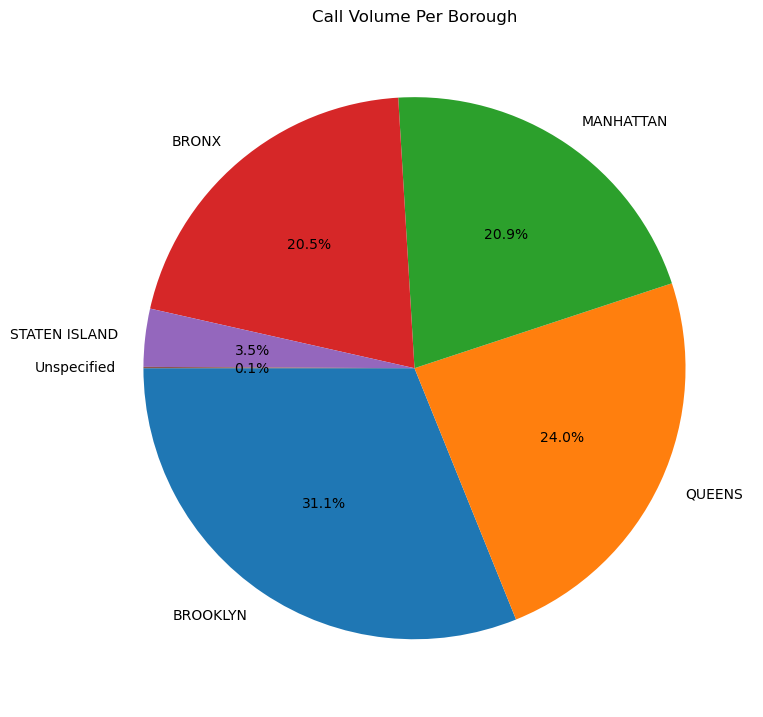

In [885]:
# create a pie chart to display the findings 

borough_call_count= nyc311_location['borough'].value_counts()
plt.figure(figsize=(8.8,8.8)) # Setting the Figure Size of the Pie Graph
borough_call_count.plot.pie(autopct='%1.1f%%', startangle=180) # Setting Up and Coding the Pie Chart
plt.title('Call Volume Per Borough') # Title of Pie Chart
plt.ylabel('') # Gets Rid of Text on Y-axis
plt.show() # Displays Pie Chart

In [886]:
complaint_df = nyc311_service_line['complaint_type'].value_counts()
complaint_df.head()

complaint_type
Illegal Parking         123083
HEAT/HOT WATER          106450
Noise - Residential      68498
Blocked Driveway         43067
UNSANITARY CONDITION     28192
Name: count, dtype: int64

In [887]:
complaint_df = nyc311_service_line['complaint_type'].value_counts()
complaint_df.tail()

complaint_type
Building Marshals office           1
Construction Safety Enforcement    1
DSNY Internal                      1
Executive Inspections              1
Radioactive Material               1
Name: count, dtype: int64

In [889]:
complaints_per_borough = nyc311_service_line[['complaint_type', 'borough']]
complaints_per_borough.head()


,complaint_type,borough
0,Food Poisoning,BROOKLYN
1,Street Sign - Damaged,BROOKLYN
2,HEAT/HOT WATER,BRONX
3,HEAT/HOT WATER,MANHATTAN
4,Street Condition,MANHATTAN


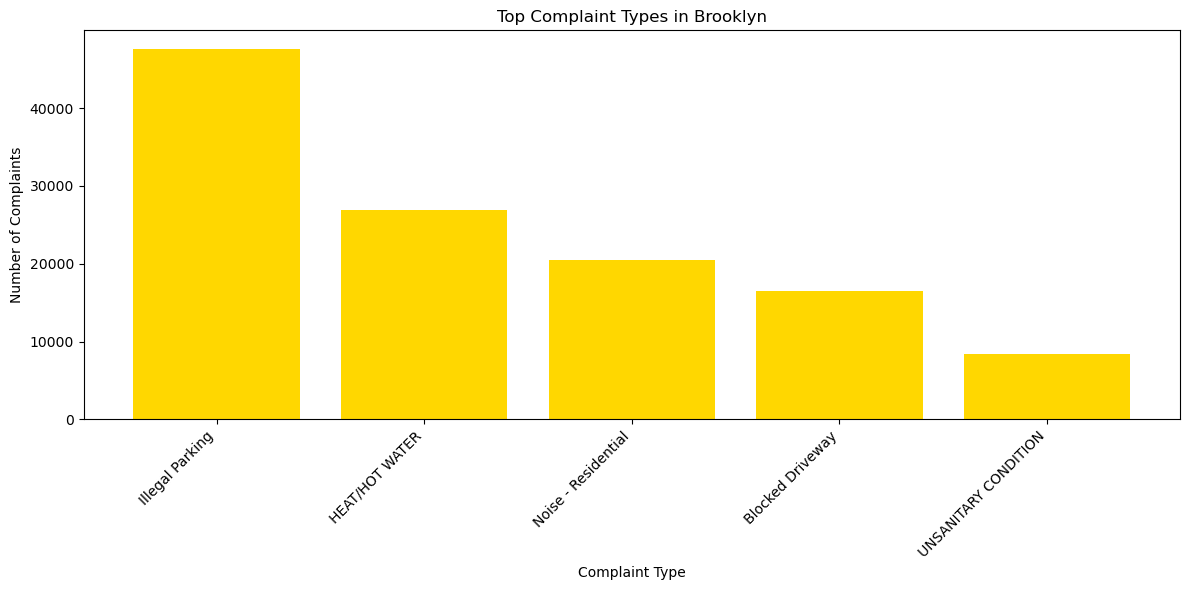

In [894]:
brooklyn_complaints = nyc311_service_line[nyc311_service_line['borough'] == 'BROOKLYN']
brooklyn_complaints_counts = brooklyn_complaints.groupby('complaint_type').size()
brooklyn_complaints_df = brooklyn_complaints_counts.reset_index(name='count')
brooklyn_complaints_sorted = brooklyn_complaints_df.sort_values(by='count', ascending=False)
brooklyn_complaints_sorted.head()

# Create the bar graph
plt.figure(figsize=(12, 6))
plt.bar(brooklyn_complaints_sorted['complaint_type'][:5], brooklyn_complaints_sorted['count'][:5], color='gold')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.title('Top Complaint Types in Brooklyn')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

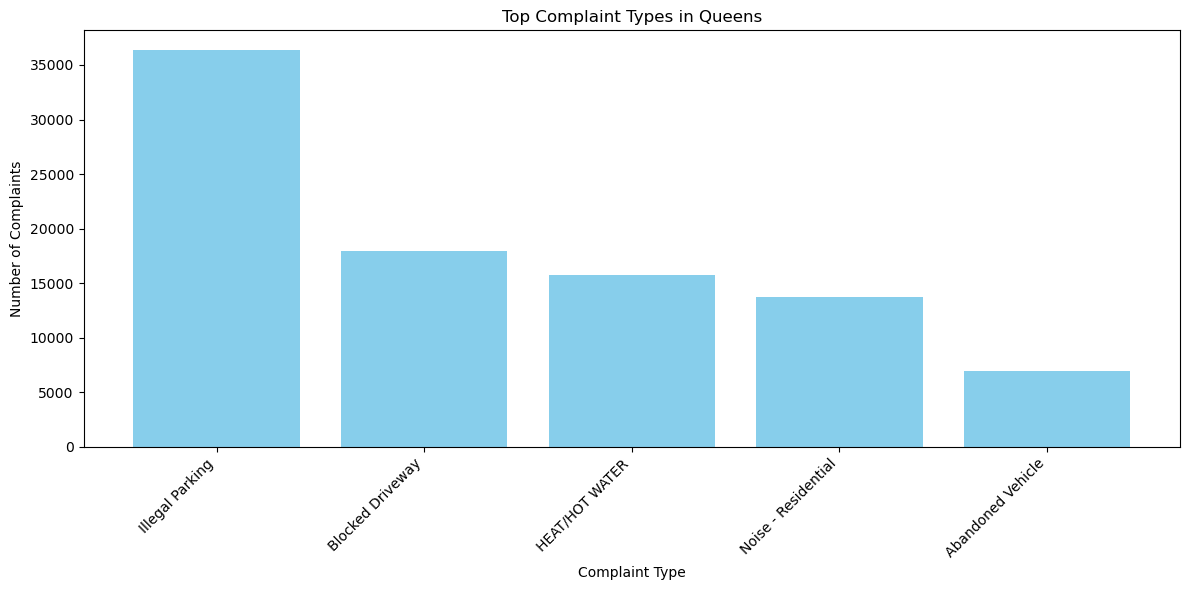

In [893]:
queens_complaints = nyc311_service_line[nyc311_service_line['borough'] == 'QUEENS']
queens_complaints_counts = queens_complaints.groupby('complaint_type').size()
queens_complaints_df = queens_complaints_counts.reset_index(name='count')
queens_complaints_sorted = queens_complaints_df.sort_values(by='count', ascending=False)
queens_complaints_sorted.head()

plt.figure(figsize=(12, 6))
plt.bar(queens_complaints_sorted['complaint_type'][:5], queens_complaints_sorted['count'][:5], color='skyblue')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.title('Top Complaint Types in Queens')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

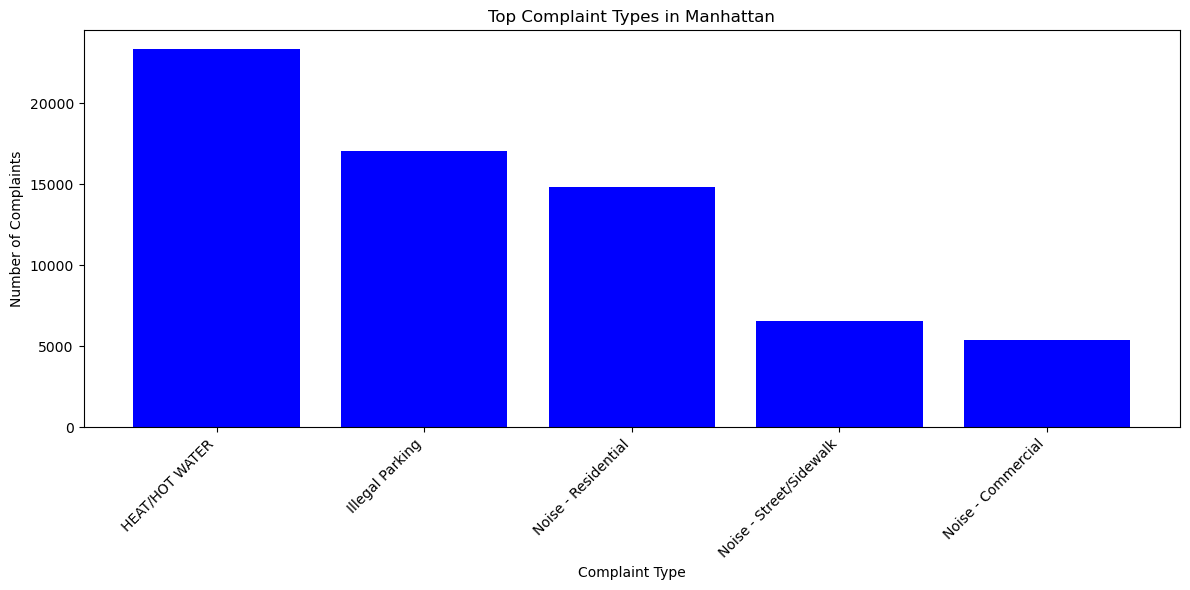

In [895]:
manhattan_complaints = nyc311_service_line[nyc311_service_line['borough'] == 'MANHATTAN']
manhattan_complaints_counts = manhattan_complaints.groupby('complaint_type').size()
manhattan_complaints_df = manhattan_complaints_counts.reset_index(name='count')
manhattan_complaints_sorted = manhattan_complaints_df.sort_values(by='count', ascending=False)
manhattan_complaints_sorted.head()

plt.figure(figsize=(12, 6))
plt.bar(manhattan_complaints_sorted['complaint_type'][:5], manhattan_complaints_sorted['count'][:5], color='blue')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.title('Top Complaint Types in Manhattan')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

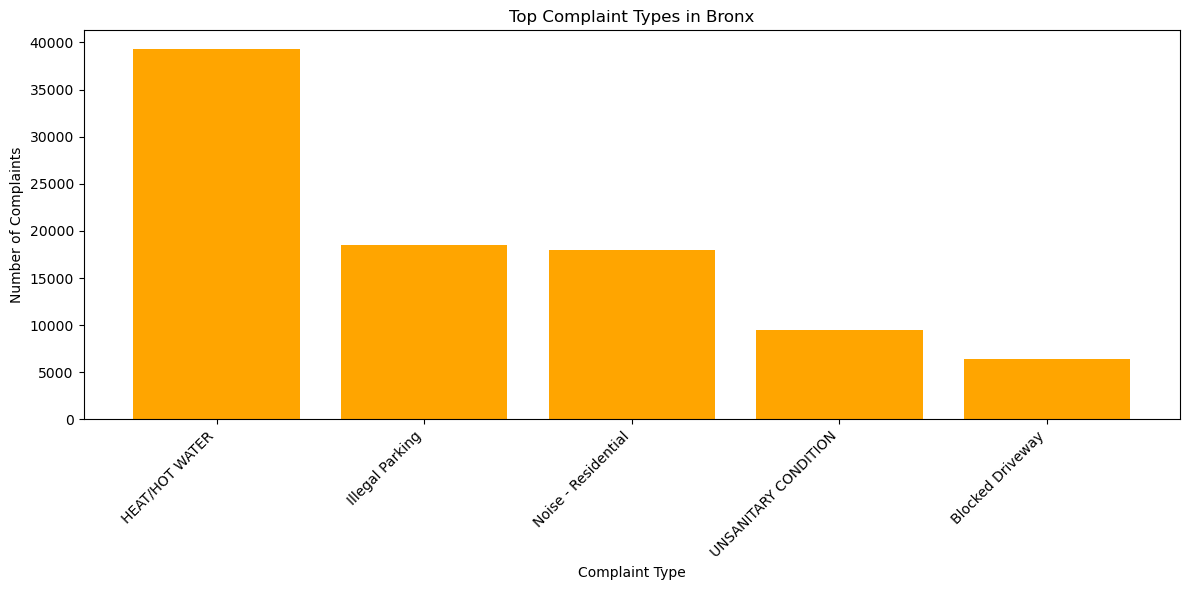

In [896]:
bronx_complaints = nyc311_service_line[nyc311_service_line['borough'] == 'BRONX']
bronx_complaints_counts = bronx_complaints.groupby('complaint_type').size()
bronx_complaints_df = bronx_complaints_counts.reset_index(name='count')
bronx_complaints_sorted = bronx_complaints_df.sort_values(by='count', ascending=False)
bronx_complaints_sorted.head()

plt.figure(figsize=(12, 6))
plt.bar(bronx_complaints_sorted['complaint_type'][:5], bronx_complaints_sorted['count'][:5], color='orange')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.title('Top Complaint Types in Bronx')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


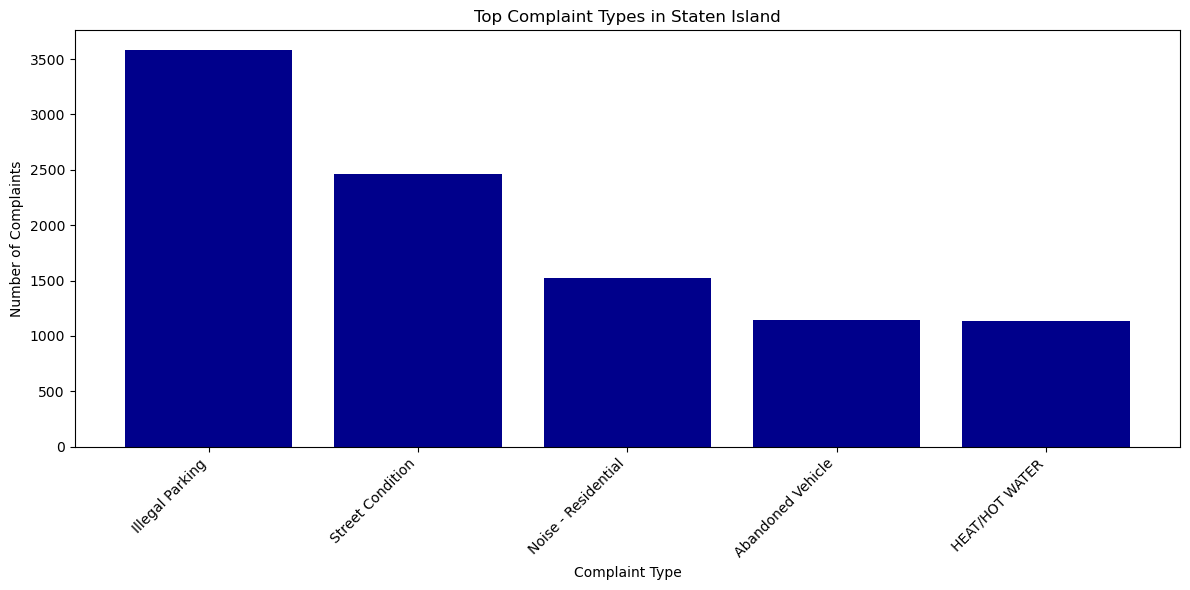

In [897]:
staten_island_complaints = nyc311_service_line[nyc311_service_line['borough'] == 'STATEN ISLAND']
staten_island_complaints_counts = staten_island_complaints.groupby('complaint_type').size()
staten_island_complaints_df = staten_island_complaints_counts.reset_index(name='count')
staten_island_complaints_sorted = staten_island_complaints_df.sort_values(by='count', ascending=False)
staten_island_complaints_sorted.head()

plt.figure(figsize=(12, 6))
plt.bar(staten_island_complaints_sorted['complaint_type'][:5], staten_island_complaints_sorted['count'][:5], color='darkblue')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.title('Top Complaint Types in Staten Island')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [902]:
complaints_count = complaints_per_borough.groupby(['borough', 'complaint_type']).size().reset_index(name='count')
highest_complaint_idx = complaints_count.groupby('borough')['count'].idxmax()
highest_complaints_per_borough = complaints_count.loc[highest_complaint_idx].reset_index(drop=True)
highest_complaints_per_borough.index = highest_complaints_per_borough.index + 1
highest_complaints_per_borough

,borough,complaint_type,count
1,BRONX,HEAT/HOT WATER,39312
2,BROOKLYN,Illegal Parking,47599
3,MANHATTAN,HEAT/HOT WATER,23341
4,QUEENS,Illegal Parking,36358
5,STATEN ISLAND,Illegal Parking,3580
6,Unspecified,Ferry Inquiry,75


In [903]:
complaints_count = complaints_per_borough.groupby(['borough', 'complaint_type']).size().reset_index(name='count')
lowest_complaint_idx = complaints_count.groupby('borough')['count'].idxmin()
lowest_complaints_per_borough = complaints_count.loc[lowest_complaint_idx].reset_index(drop=True)
lowest_complaints_per_borough.index = lowest_complaints_per_borough.index + 1
lowest_complaints_per_borough

,borough,complaint_type,count
1,BRONX,Animal Facility - No Permit,1
2,BROOKLYN,Animal Facility - No Permit,1
3,MANHATTAN,Building Condition,1
4,QUEENS,Building Marshals office,1
5,STATEN ISLAND,Borough Office,1
6,Unspecified,Bike Rack Condition,1


### What Agency Has The Highest Call Rate?
----

In [904]:
#Finding the unique value of agencies. I am looking to see which agencies are taking care of the complaints at NYC311 and how many /
# complaints they each got between 01/01/24 and 04/01/24.
unique_agency = nyc311_service_line["agency"].value_counts()
unique_agency

agency
NYPD     316884
HPD      228164
DSNY      65662
DOT       53678
DEP       38572
DOB       24812
DPR       19684
DOHMH     19168
TLC        8869
DHS        7190
EDC        7006
DCWP       4256
DOE         370
OTI          39
Name: count, dtype: int64

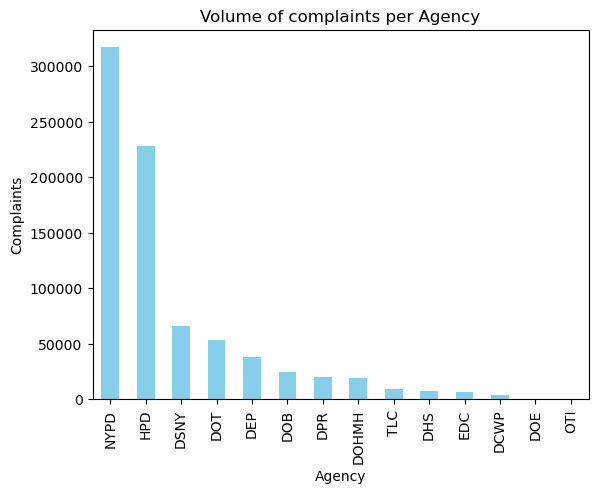

In [906]:
#Creating a dataframe referencing only the complaint types and the corresponding agencies. This will be the dataframe used to create my other / 
#following dataframes for my visualizations
agency_per_complaint = nyc311_service_line[['complaint_type', 'agency']]
agency_per_complaint.head()


#Display bar chart referencing the volume of complaint type per agency 
unique_agency.plot(x='agency', y='complaint_type', kind='bar', color='skyblue')
plt.xlabel('Agency')
plt.ylabel('Complaints')
plt.title('Volume of complaints per Agency')

plt.show()


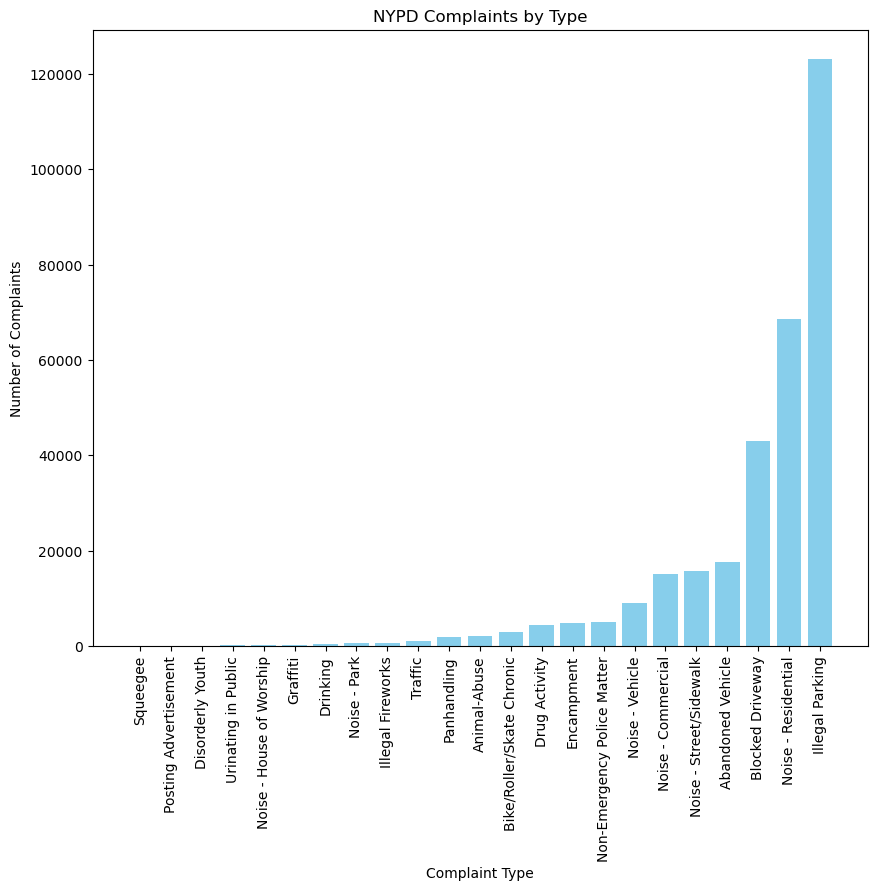

In [910]:
#Calculating for count of complaints for each complaint type only for NYPD.
nypd_complaints = agency_per_complaint.query('agency == "NYPD"').groupby('complaint_type').size().reset_index(name='NYPD')
nypd_complaints = nypd_complaints.sort_values(by=['NYPD', 'complaint_type'])
nypd_complaints = nypd_complaints.reset_index(drop=True)
nypd_complaints

# Creating a histogram for NYPD using the previous data from nypd_complaints.
plt.figure(figsize=(10,8))
plt.bar(nypd_complaints['complaint_type'], nypd_complaints['NYPD'], color='skyblue')
plt.title('NYPD Complaints by Type')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=90)
nypd_complaints.sort_values('complaint_type')
plt.show()

In [911]:
# Creating a new dataframe with the columns: agency, complaint_type and created_date. 
nypd_date = nyc311_service_line[(nyc311_service_line['agency'] == 'NYPD')]
nypd_date = nypd_date[['agency', 'complaint_type', 'created_date']]
nypd_date.head()

,agency,complaint_type,created_date
5,NYPD,Noise - Residential,2024-03-31 23:58:32
6,NYPD,Noise - Commercial,2024-03-31 23:58:22
7,NYPD,Illegal Parking,2024-03-31 23:58:21
8,NYPD,Noise - Street/Sidewalk,2024-03-31 23:58:12
9,NYPD,Illegal Parking,2024-03-31 23:57:53


In [912]:
#I am now analyzing the top 3 complaints for NYPD. NYPD is number one./
# Creating a dataframe referencing the total number of illegal parking complaints for each day between 01/01/24 and 04/01/24.
nypd_date['created_date'] = pd.to_datetime(nypd_date['created_date'])
nypd_date['created_date'] = nypd_date['created_date'].dt.date
illegal_parking_counts = nypd_date[nypd_date['complaint_type'] == 'Illegal Parking'].groupby('created_date').size().reset_index(name='Illegal parking')
illegal_parking_counts.head()

,created_date,Illegal parking
0,2024-01-01,1167
1,2024-01-02,1410
2,2024-01-03,1468
3,2024-01-04,1519
4,2024-01-05,1497


In [913]:
# Creating a dataframe referencing the total number of residential noise complaints for each day between 01/01/24 and 04/01/24.
nypd_date['created_date'] = pd.to_datetime(nypd_date['created_date'])
nypd_date['created_date'] = nypd_date['created_date'].dt.date
noise_residential_counts = nypd_date[nypd_date['complaint_type'] == 'Noise - Residential'].groupby('created_date').size().reset_index(name='Residential noise')
noise_residential_counts.head()

,created_date,Residential noise
0,2024-01-01,1481
1,2024-01-02,605
2,2024-01-03,657
3,2024-01-04,562
4,2024-01-05,605


In [914]:
# Creating a dataframe referencing the total number of blocked driveway complaints for each day between 01/01/24 and 04/01/24.
nypd_date['created_date'] = pd.to_datetime(nypd_date['created_date'])
nypd_date['created_date'] = nypd_date['created_date'].dt.date
blocked_driveway_counts = nypd_date[nypd_date['complaint_type'] == 'Blocked Driveway'].groupby('created_date').size().reset_index(name='Blocked driveway')
blocked_driveway_counts.head()

,created_date,Blocked driveway
0,2024-01-01,573
1,2024-01-02,500
2,2024-01-03,485
3,2024-01-04,509
4,2024-01-05,534


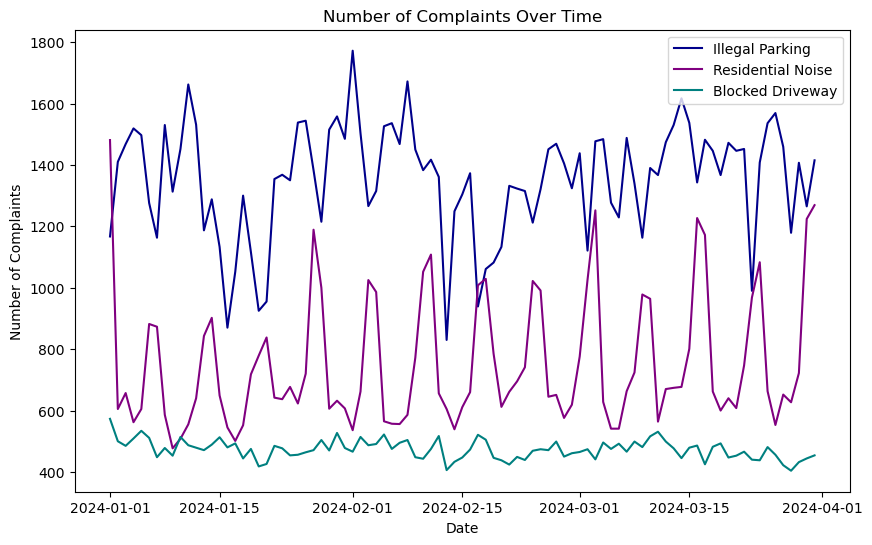

In [916]:
#Merging all three dataframes to create a line graph and study the evolution of the three NYPD biggest complaints over 3 months. 
nypd_complaints_counts = illegal_parking_counts.merge(noise_residential_counts, on='created_date', how='outer').merge(blocked_driveway_counts, on='created_date', how='outer').fillna(0)
nypd_complaints_counts.head()

# Creating line graph
# Convert the 'created_date' column to datetime objects
nypd_complaints_counts['created_date'] = pd.to_datetime(nypd_complaints_counts['created_date'])

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(nypd_complaints_counts['created_date'], nypd_complaints_counts['Illegal parking'], label='Illegal Parking', color='darkblue')
plt.plot(nypd_complaints_counts['created_date'], nypd_complaints_counts['Residential noise'], label='Residential Noise', color='purple')
plt.plot(nypd_complaints_counts['created_date'], nypd_complaints_counts['Blocked driveway'], label='Blocked Driveway', color='teal')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints Over Time')

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [917]:
#Calculating for count of complaints for each complaint type only for HPD.
hpd_complaints = agency_per_complaint.query('agency == "HPD"').groupby('complaint_type').size().reset_index(name='HPD')
hpd_complaints = hpd_complaints.sort_values(by=['HPD', 'complaint_type'])
hpd_complaints = hpd_complaints.reset_index(drop=True)
hpd_complaints

# Creating a histogram for HPD using the previous data from hpd_complaints.
plt.figure(figsize=(10,8))
plt.bar(hpd_complaints['complaint_type'], hpd_complaints['HPD'], color='skyblue')
plt.title('HPD Complaints by Type')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=90)
hpd_complaints.sort_values('complaint_type')
plt.show()

          complaint_type     HPD
0       OUTSIDE BUILDING     394
1               ELEVATOR     401
2                 SAFETY    3333
3              APPLIANCE    5353
4        FLOORING/STAIRS    7137
5               ELECTRIC    7222
6                GENERAL    8257
7            DOOR/WINDOW   12755
8             WATER LEAK   13933
9          PAINT/PLASTER   17331
10              PLUMBING   17406
11  UNSANITARY CONDITION   28192
12        HEAT/HOT WATER  106450


In [918]:
# Creating a new dataframe with the columns: agency, complaint_type and created_date. 
hpd_date = nyc311_service_line[(nyc311_service_line['agency'] == 'HPD')]
hpd_date = hpd_date[['agency', 'complaint_type', 'created_date']]
hpd_date.head()


,agency,complaint_type,created_date
2,HPD,HEAT/HOT WATER,2024-03-31 23:59:09
3,HPD,HEAT/HOT WATER,2024-03-31 23:58:47
22,HPD,HEAT/HOT WATER,2024-03-31 23:55:44
42,HPD,HEAT/HOT WATER,2024-03-31 23:52:15
67,HPD,WATER LEAK,2024-03-31 23:46:32


In [925]:
#I am now analyzing the top 3 complaints for HPD. HPD is number two./
# Creating a dataframe referencing the total number of HEAT/HOT WATER complaints for each day between 01/01/24 and 04/01/24.
hpd_date['created_date'] = pd.to_datetime(hpd_date['created_date'])
hpd_date['created_date'] = hpd_date['created_date'].dt.date
heat_hot_water_counts = hpd_date[hpd_date['complaint_type'] == 'HEAT/HOT WATER'].groupby('created_date').size().reset_index(name='HEAT/HOT WATER')
heat_hot_water_counts.head()


# Creating a dataframe referencing the total number of UNSANITARY CONDITION complaints for each day between 01/01/24 and 04/01/24.
hpd_date['created_date'] = pd.to_datetime(hpd_date['created_date'])
hpd_date['created_date'] = hpd_date['created_date'].dt.date
unsanitary_condition_counts = hpd_date[hpd_date['complaint_type'] == 'UNSANITARY CONDITION'].groupby('created_date').size().reset_index(name='UNSANITARY CONDITION')
unsanitary_condition_counts.head()

# Creating a dataframe referencing the total number of PLUMBING complaints for each day between 01/01/24 and 04/01/24.
hpd_date['created_date'] = pd.to_datetime(hpd_date['created_date'])
hpd_date['created_date'] = hpd_date['created_date'].dt.date
plumbing_counts = hpd_date[hpd_date['complaint_type'] == 'PLUMBING'].groupby('created_date').size().reset_index(name='PLUMBING')
plumbing_counts.head()

,created_date,PLUMBING
0,2024-01-01,104
1,2024-01-02,252
2,2024-01-03,239
3,2024-01-04,263
4,2024-01-05,215


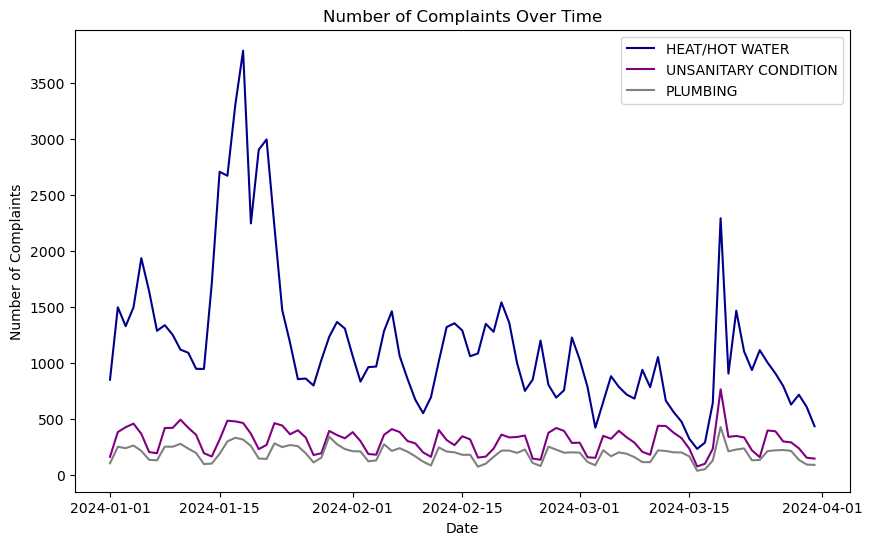

In [924]:
#Merging all three dataframes to create a line graph and study the evolution of the three HPD biggest complaints over 3 months. 
hpd_complaints_counts = heat_hot_water_counts.merge(unsanitary_condition_counts, on='created_date', how='outer').merge(plumbing_counts, on='created_date', how='outer').fillna(0)
hpd_complaints_counts.head()


# Creating line graph
# Convert the 'created_date' column to datetime objects
hpd_complaints_counts['created_date'] = pd.to_datetime(hpd_complaints_counts['created_date'])

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(hpd_complaints_counts['created_date'], hpd_complaints_counts['HEAT/HOT WATER'], label='HEAT/HOT WATER', color='darkblue')
plt.plot(hpd_complaints_counts['created_date'], hpd_complaints_counts['UNSANITARY CONDITION'], label='UNSANITARY CONDITION', color='purple')
plt.plot(hpd_complaints_counts['created_date'], hpd_complaints_counts['PLUMBING'], label='PLUMBING', color='grey')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints Over Time')

# Add a legend
plt.legend()

# Display the plot
plt.show()

                            complaint_type   DSNY
0                            DSNY Internal      1
1                         Oil or Gas Spill      2
2                           Incorrect Data      5
3           Institution Disposal Complaint      9
4                       Retailer Complaint      9
5               Recycling Basket Complaint     10
6                           Adopt-A-Basket     14
7                      Seasonal Collection    140
8                  Litter Basket Complaint    207
9                            Lot Condition    264
10                      Dumpster Complaint    378
11                          Abandoned Bike    533
12  Sanitation Worker or Vehicle Complaint    580
13                   Litter Basket Request    777
14                         Illegal Posting    908
15           Commercial Disposal Complaint   1018
16               Street Sweeping Complaint   1644
17                             Dead Animal   2014
18          Residential Disposal Complaint   2912


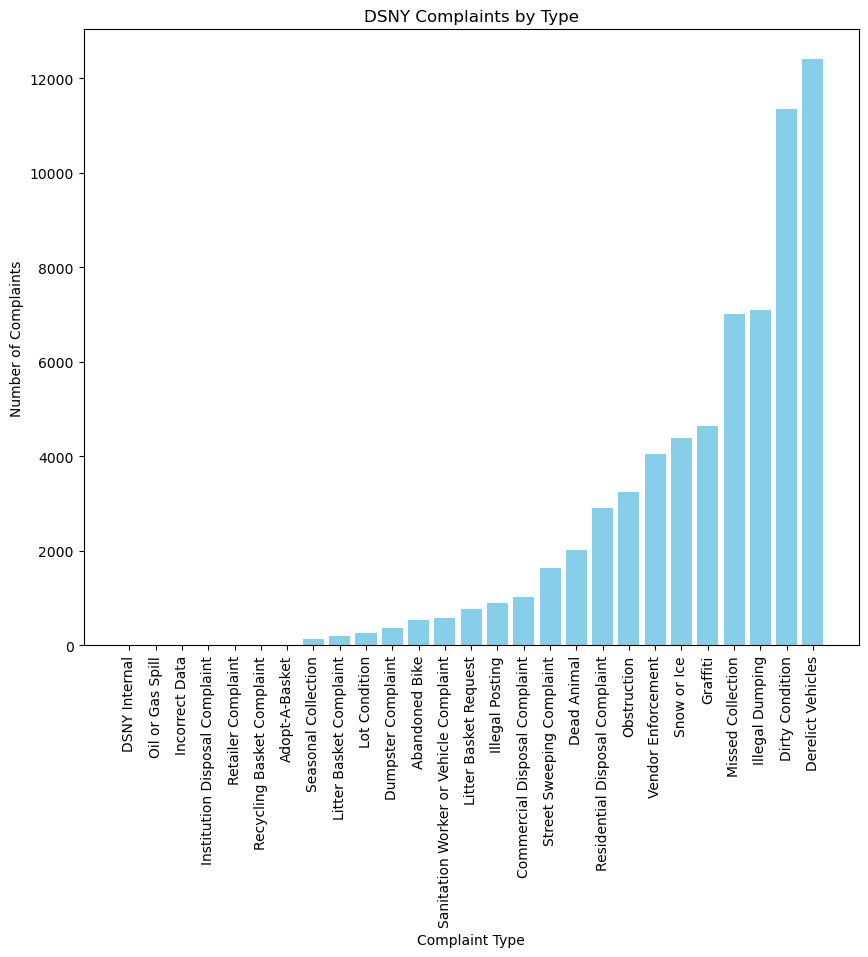

In [926]:
#Calculating for count of complaints for each complaint type only for DSNY.
dsny_complaints = agency_per_complaint.query('agency == "DSNY"').groupby('complaint_type').size().reset_index(name='DSNY')
dsny_complaints = dsny_complaints.sort_values(by=['DSNY', 'complaint_type'])
dsny_complaints = dsny_complaints.reset_index(drop=True)
print(dsny_complaints)

# Creating a histogram for HPD using the previous data from dsny_complaints.
plt.figure(figsize=(10,8))
plt.bar(dsny_complaints['complaint_type'], dsny_complaints['DSNY'], color='skyblue')
plt.title('DSNY Complaints by Type')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=90)
dsny_complaints.sort_values('complaint_type')
plt.show()

In [929]:
# Creating a new dataframe with the columns: agency, complaint_type and created_date. 
dsny_date = nyc311_service_line[(nyc311_service_line['agency'] == 'DSNY')]
dsny_date = dsny_date[['agency', 'complaint_type', 'created_date']]
dsny_date

#I am now analyzing the top 4 complaints for HPD. HPD is number two./
#I am analyzing the 4th biggest complaint because Missed Collection is linked to the current NYC trash problem.
# Creating a dataframe referencing the total number of Derelict Vehicles complaints for each day between 01/01/24 and 04/01/24.
dsny_date['created_date'] = pd.to_datetime(dsny_date['created_date'])
dsny_date['created_date'] = dsny_date['created_date'].dt.date
derelict_vehicles_counts = dsny_date[dsny_date['complaint_type'] == 'Derelict Vehicles'].groupby('created_date').size().reset_index(name='Derelict Vehicles')
derelict_vehicles_counts.head()



,created_date,Derelict Vehicles
0,2024-01-01,82
1,2024-01-02,132
2,2024-01-03,150
3,2024-01-04,178
4,2024-01-05,164


In [931]:
# Creating a dataframe referencing the total number of Dirty Condition complaints for each day between 01/01/24 and 04/01/24.
dsny_date['created_date'] = pd.to_datetime(dsny_date['created_date'])
dsny_date['created_date'] = dsny_date['created_date'].dt.date
dirty_condition_counts = dsny_date[dsny_date['complaint_type'] == 'Dirty Condition'].groupby('created_date').size().reset_index(name='Dirty Condition')
dirty_condition_counts

#creating a dataframe referencing the total number of Illegal Dumping complaints for each day between 01/01/24 and 04/01/24.
dsny_date['created_date'] = pd.to_datetime(dsny_date['created_date'])
dsny_date['created_date'] = dsny_date['created_date'].dt.date
illegal_dumping_counts = dsny_date[dsny_date['complaint_type'] == 'Illegal Dumping'].groupby('created_date').size().reset_index(name='Illegal Dumping')
illegal_dumping_counts

# Creating a dataframe referencing the total number of Missed Collection complaints for each day between 01/01/24 and 04/01/24.
dsny_date['created_date'] = pd.to_datetime(dsny_date['created_date'])
dsny_date['created_date'] = dsny_date['created_date'].dt.date
missed_collection_counts = dsny_date[dsny_date['complaint_type'] == 'Missed Collection'].groupby('created_date').size().reset_index(name='Missed Collection')
missed_collection_counts.head()

,created_date,Missed Collection
0,2024-01-01,17
1,2024-01-02,15
2,2024-01-03,3
3,2024-01-04,7
4,2024-01-05,159


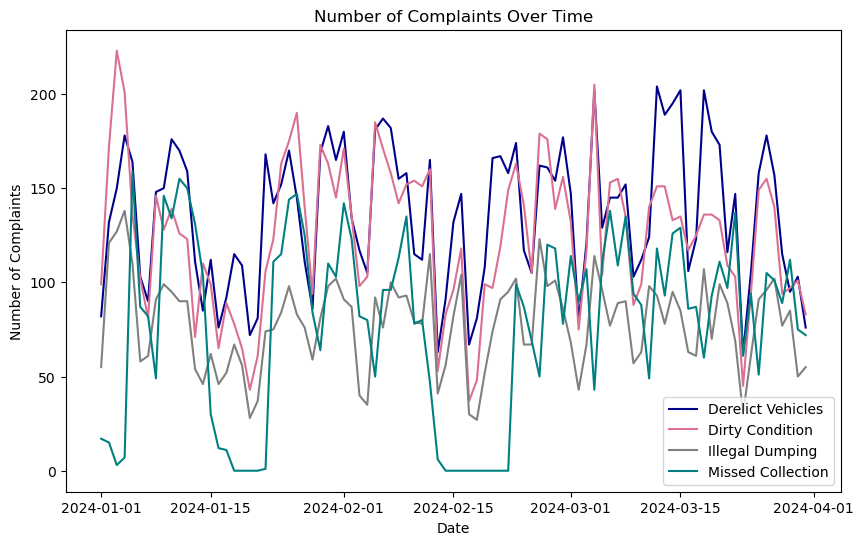

In [932]:
#Merging all four dataframes to create a line graph and study the evolution of the three HPD biggest complaints over 3 months. 
dsny_complaints_counts = derelict_vehicles_counts.merge(dirty_condition_counts, on='created_date', how='outer').merge(illegal_dumping_counts, on='created_date', how='outer').merge(missed_collection_counts, on='created_date', how='outer').fillna(0)
dsny_complaints_counts

# Creating line graph
# Convert the 'created_date' column to datetime objects
dsny_complaints_counts['created_date'] = pd.to_datetime(dsny_complaints_counts['created_date'])

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(dsny_complaints_counts['created_date'], dsny_complaints_counts['Derelict Vehicles'], label='Derelict Vehicles', color='darkblue')
plt.plot(dsny_complaints_counts['created_date'], dsny_complaints_counts['Dirty Condition'], label='Dirty Condition', color='palevioletred')
plt.plot(dsny_complaints_counts['created_date'], dsny_complaints_counts['Illegal Dumping'], label='Illegal Dumping', color='grey')
plt.plot(dsny_complaints_counts['created_date'], dsny_complaints_counts['Missed Collection'], label='Missed Collection', color='teal')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints Over Time')

# Add a legend
plt.legend()

# Display the plot
plt.show()

### Extracting NYC API Developers data from api-portal.nyc.gov

In [936]:
# URL for GET requests to retrieve vehicle data
url_calendar= f'https://api.nyc.gov/public/api/GetCalendar?fromdate={fromdate}&todate={todate}'
headers = {'Ocp-Apim-Subscription-Key': api_key}

In [937]:
# Print the response object to the console
response = requests.get(url_calendar, headers=headers)
print(response.status_code)

200


In [938]:
# Retrieving data and converting it into JSON
response_json =response.json()

In [939]:
# Pretty Print the output of the JSON
print(json.dumps(response_json, indent=4, sort_keys=True))

{
    "days": [
        {
            "items": [
                {
                    "details": "Alternate side parking and meters are in effect.",
                    "status": "IN EFFECT",
                    "type": "Alternate Side Parking"
                },
                {
                    "details": "Trash, recycling, and compost collections are on schedule.",
                    "status": "ON SCHEDULE",
                    "type": "Collections"
                },
                {
                    "details": "Public schools are open.",
                    "status": "OPEN",
                    "type": "Schools"
                }
            ],
            "today_id": "20240131"
        },
        {
            "items": [
                {
                    "details": "Alternate side parking and meters are in effect.",
                    "status": "IN EFFECT",
                    "type": "Alternate Side Parking"
                },
                {
                   

In [942]:
#create a dataframe from json response 
api_df = response_json
api_df

{'days': [{'today_id': '20240131',
   'items': [{'details': 'Alternate side parking and meters are in effect.',
     'status': 'IN EFFECT',
     'type': 'Alternate Side Parking'},
    {'details': 'Trash, recycling, and compost collections are on schedule.',
     'status': 'ON SCHEDULE',
     'type': 'Collections'},
    {'details': 'Public schools are open.',
     'status': 'OPEN',
     'type': 'Schools'}]},
  {'today_id': '20240201',
   'items': [{'details': 'Alternate side parking and meters are in effect.',
     'status': 'IN EFFECT',
     'type': 'Alternate Side Parking'},
    {'details': 'Trash, recycling, and compost collections are on schedule.',
     'status': 'ON SCHEDULE',
     'type': 'Collections'},
    {'details': 'Public schools are open.',
     'status': 'OPEN',
     'type': 'Schools'}]},
  {'today_id': '20240202',
   'items': [{'details': 'Alternate side parking and meters are in effect.',
     'status': 'IN EFFECT',
     'type': 'Alternate Side Parking'},
    {'details'

In [944]:
#create a empty list to store data
rows = []
# Loop through the data and extract information
for day in api_df['days']:
    today_id = day['today_id']
    for type in day['items']:
        row = {'today_id': today_id}
        row.update(type)
        rows.append(row)
trash_cleaned_df = pd.DataFrame(rows)
#display dataframe 
trash_cleaned_df.head()

,today_id,details,status,type,exceptionName
0,20240131,Alternate side parking and meters are in effect.,IN EFFECT,Alternate Side Parking,NaN
1,20240131,"Trash, recycling, and compost collections are ...",ON SCHEDULE,Collections,NaN
2,20240131,Public schools are open.,OPEN,Schools,NaN
3,20240201,Alternate side parking and meters are in effect.,IN EFFECT,Alternate Side Parking,NaN
4,20240201,"Trash, recycling, and compost collections are ...",ON SCHEDULE,Collections,NaN


In [945]:
collections_list = []

# Iterating over each 'day' in the 'days' column of api_df
for day in api_df['days']:
    # Iterating over each 'item' in the 'items' list of the current 'day'
    for item in day['items']:
        # Appending a dictionary to collections_list for each 'item'
        collections_list.append({
            'today_id': day['today_id'],  # Storing 'today_id' from the current 'day'
            'status': item['status'],     # Storing 'status' from the current 'item'
            'type': item['type']          # Storing 'type' from the current 'item'
        })

# Creating a DataFrame using collections_list
types_df = pd.DataFrame(collections_list)

# Filtering rows in types_df where 'type' column equals 'Collections'
specific_type = 'Collections'
trash_filtered_df = types_df[types_df['type'] == specific_type]

# Displaying the first few rows of the filtered DataFrame
trash_filtered_df.head()

,today_id,status,type
1,20240131,ON SCHEDULE,Collections
4,20240201,ON SCHEDULE,Collections
7,20240202,ON SCHEDULE,Collections
10,20240203,ON SCHEDULE,Collections
13,20240204,NOT IN EFFECT,Collections


In [946]:
#Now let's look at the trash problem in NYC. I have done a quick analysis of trash collection. Should NYC get trash cans or not ? 
#Create a empty list to store data
rows = []
# Loop through the data and extract information
for day in api_df['days']:
    today_id = day['today_id']
    for type in day['items']:
        row = {'today_id': today_id}
        row.update(type)
        rows.append(row)
trash_cleaned_df = pd.DataFrame(rows)
#Display dataframe 
trash_cleaned_df.head()

,today_id,details,status,type,exceptionName
0,20240131,Alternate side parking and meters are in effect.,IN EFFECT,Alternate Side Parking,NaN
1,20240131,"Trash, recycling, and compost collections are ...",ON SCHEDULE,Collections,NaN
2,20240131,Public schools are open.,OPEN,Schools,NaN
3,20240201,Alternate side parking and meters are in effect.,IN EFFECT,Alternate Side Parking,NaN
4,20240201,"Trash, recycling, and compost collections are ...",ON SCHEDULE,Collections,NaN


In [947]:
#Creating a dataframe with today_id, status and type
collections_list = []

# Iterating over each 'day' in the 'days' column of api_df
for day in api_df['days']:
    # Iterating over each 'item' in the 'items' list of the current 'day'
    for item in day['items']:
        # Appending a dictionary to collections_list for each 'item'
        collections_list.append({
            'today_id': day['today_id'],  # Storing 'today_id' from the current 'day'
            'status': item['status'],     # Storing 'status' from the current 'item'
            'type': item['type']          # Storing 'type' from the current 'item'
        })

# Creating a DataFrame using collections_list
types_df = pd.DataFrame(collections_list)

# Filtering rows in types_df where 'type' column equals 'Collections'
specific_type = 'Collections'
trash_filtered_df = types_df[types_df['type'] == specific_type]

# Displaying the first few rows of the filtered DataFrame
trash_filtered_df.head()


,today_id,status,type
1,20240131,ON SCHEDULE,Collections
4,20240201,ON SCHEDULE,Collections
7,20240202,ON SCHEDULE,Collections
10,20240203,ON SCHEDULE,Collections
13,20240204,NOT IN EFFECT,Collections


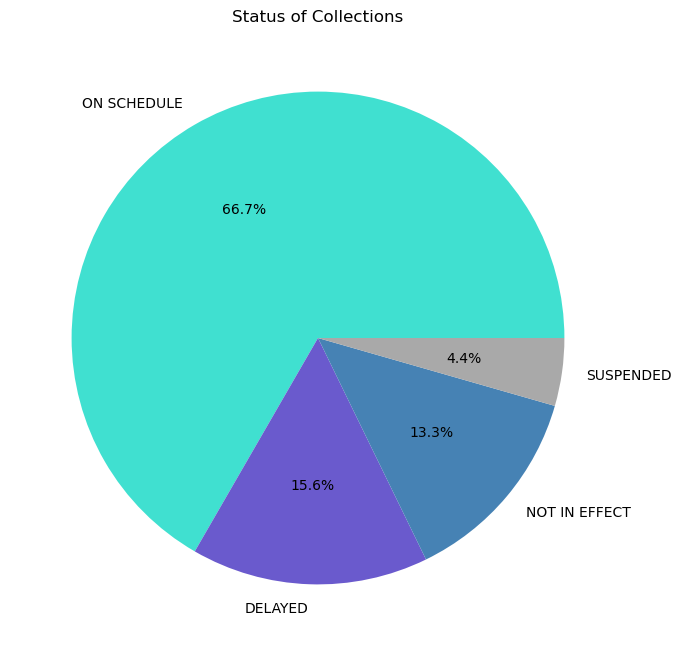

In [948]:
#Creating a piechart to diplay the results
# Counting the occurrences of each status
status_counts = trash_filtered_df['status'].value_counts()

# Creating a pie chart
plt.figure(figsize=(10,8))
plt.pie(status_counts, labels = status_counts.index, autopct='%1.1f%%', colors=['#40E0D0', '#6A5ACD', '#4682B4', '#A9A9A9'])
plt.title('Status of Collections')
plt.show()